# Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Buka direktori dataset di gdrive

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Deep Learning UAS')

# Prepocessing

In [ ]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import Model, Input
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#cek label
image_dir = Path('/content/drive/MyDrive/Deep Learning UAS')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Menggabungkan filepath dan label
image_df = pd.concat([filepaths, labels], axis=1)

#menshuffle data
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Menampilkan hasil
image_df.head(5)

Filepath       Label
0  /content/drive/MyDrive/Deep Learning UAS/GB 1/...        GB 1
1  /content/drive/MyDrive/Deep Learning UAS/GEDUN...    GEDUNG A
2  /content/drive/MyDrive/Deep Learning UAS/GB 3 ...  GB 3 DAN 4
3  /content/drive/MyDrive/Deep Learning UAS/GB 1/...        GB 1
4  /content/drive/MyDrive/Deep Learning UAS/GB 3 ...  GB 3 DAN 4

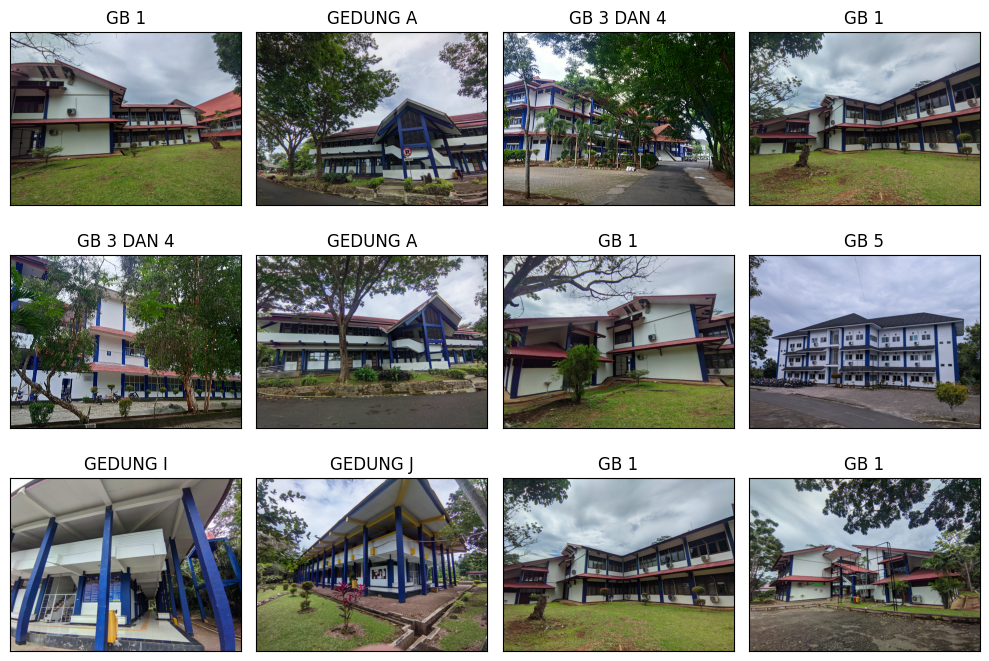

In [ ]:
# Menampilkan gambar dataset beserta hasilnya
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

<ipython-input-41-82b7d8bfcf2f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


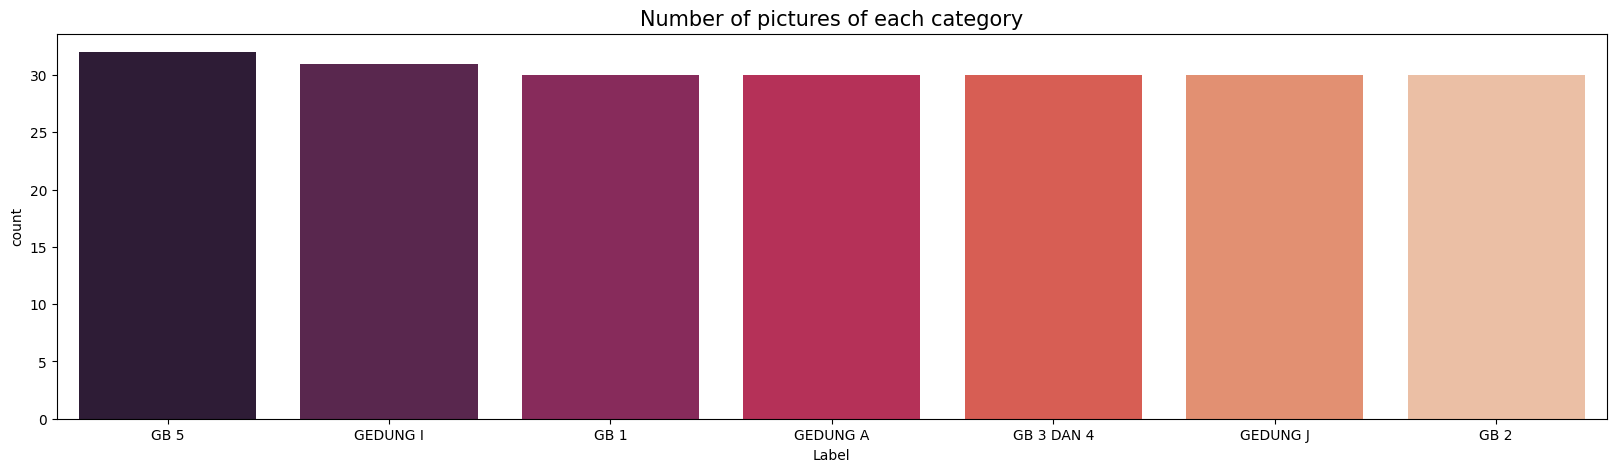

In [ ]:
# Menampilkan total gambar dari setiap kelas
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
# Membuat data untuk train dan test
img_height = 224
img_width = 224

# Load dataset untuk pelatihan
train_data = image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=(img_height, img_width),
    batch_size=16
)

# Load dataset untuk validasi sekalian testing
test_data = image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=16
)

Found 213 files belonging to 8 classes.
Using 171 files for training.
Found 213 files belonging to 8 classes.
Using 42 files for validation.


# Membangun Model

In [ ]:
base_model = EfficientNetV2B3(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D

model=Sequential(name='EfficientNetV2B3')
model.add(base_model)
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7,activation='softmax'))

model.summary()

Model: "EfficientNetV2B3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)       │ (None, 7, 7, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 1536)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 3, 3, 1536)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 13824)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       1,769,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,701,125 (56.08 MB)

 Trainable params: 14,591,909 (55.66 MB)

 Non-trainable params: 109,216 (426.62 KB)

In [ ]:
# Bangun model dengan memberikan input shape yang sesuai
model.build((None, 224, 224, 3))

In [ ]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('val_accuracy') > 0.85 and logs.get('accuracy') > 0.85):
            print("\nAkurasi sudah mendapatkan hasil yang baik!")
            self.model.stop_training = True
callbacks = EarlyStoppingAtMaxAccuracy()

In [ ]:
# Tentukan path penyimpanan model
checkpoint_path = '/content/drive/MyDrive/Deep Learning UAS/model/efficientnetv2b3.keras'

# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',  # Metrik yang akan dipantau
                                      save_best_only=True,  # Hanya menyimpan model terbaik
                                      save_weights_only=False,  # Menyimpan seluruh model
                                      mode='min',  # Mode pemantauan (misalnya, 'min', 'max', atau 'auto')
                                      verbose=1)  # Menampilkan pesan saat menyimpan

In [ ]:

model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
                  train_data,
                  batch_size=16,
                  validation_data=test_data,
                  epochs=30, callbacks=([callbacks],[checkpoint_callback]))

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7831 - loss: 0.6676   
Epoch 1: val_loss improved from inf to 0.11098, saving model to /content/drive/MyDrive/Deep Learning UAS/model/efficientnetv2b3.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 227s 10s/step - accuracy: 0.7855 - loss: 0.6629 - val_accuracy: 1.0000 - val_loss: 0.1110
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9394 - loss: 0.2376
Akurasi sudah mendapatkan hasil yang baik!

Epoch 2: val_loss improved from 0.11098 to 0.02144, saving model to /content/drive/MyDrive/Deep Learning UAS/model/efficientnetv2b3.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9391 - loss: 0.2400 - val_accuracy: 1.0000 - val_loss: 0.0214


# Saved Model to .h5

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive/Deep Learning UAS/model/"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "EfficientNetV2B3.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/Deep Learning UAS/model/H5/EfficientNetV2B3.h5...


In [ ]:
model.evaluate(test_data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 758ms/step - accuracy: 1.0000 - loss: 0.0212


[0.021443352103233337, 1.0]

# Plotting Accuration After Training and Test Model

In [ ]:
#plotting
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(6,8), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

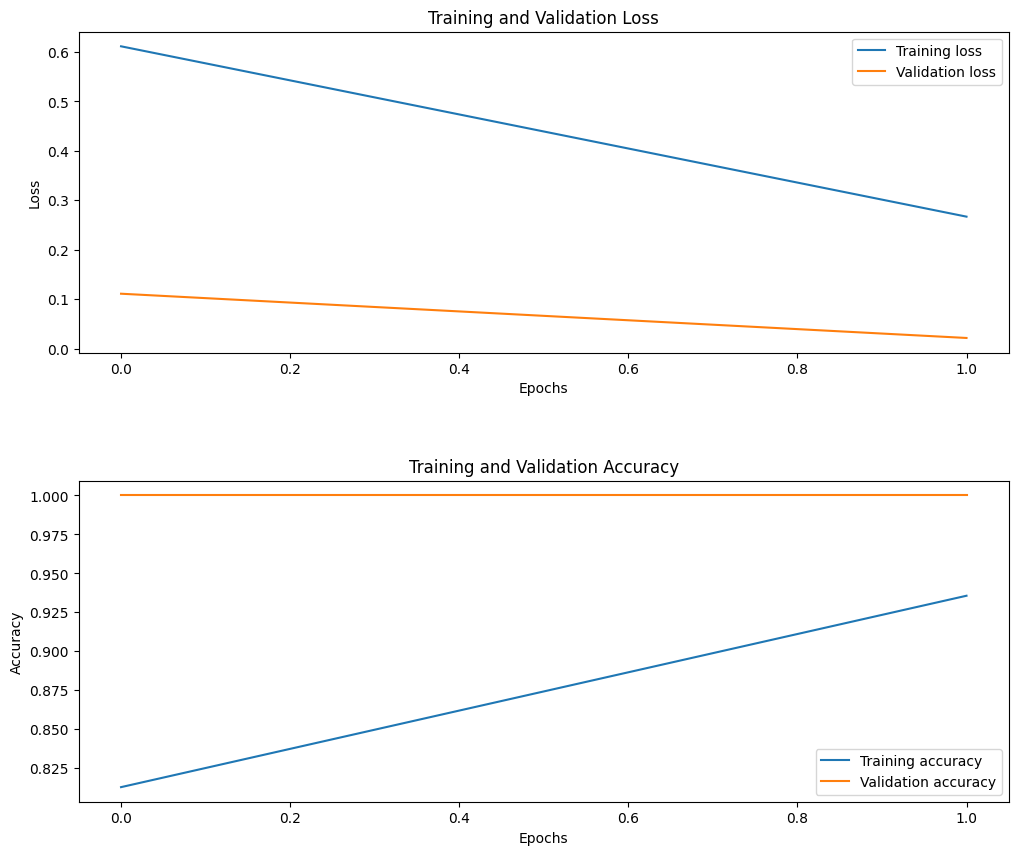

In [ ]:
def display_training_curves(training_metric, validation_metric, metric_name, subplot_position):
    plt.subplot(subplot_position)
    plt.plot(training_metric, label=f'Training {metric_name}')
    plt.plot(validation_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.title(f'Training and Validation {metric_name.capitalize()}')

# Membuat ruang antar plot
plt.figure(figsize=(12, 10))

plt.subplots_adjust(hspace=0.4)

# Plot pertama
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss', 211)

# Plot kedua
display_training_curves(
    history.history['accuracy'],
    history.history['val_accuracy'],
    'accuracy', 212)

plt.show()

In [ ]:
y_pred = model.predict(test_data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 627ms/step


In [ ]:
labels = train_data.class_names

def predict(model, img):
    # Ubah gambar menjadi array dan tambahkan dimensi batch
    img_array = np.expand_dims(img.numpy(), axis=0)

    # Lakukan prediksi
    predictions = model.predict(img_array)

    # Ambil kelas prediksi dan kepercayaan
    predicted_class = labels[np.argmax(predictions)]
    confidence = round(np.max(predictions), 2)

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


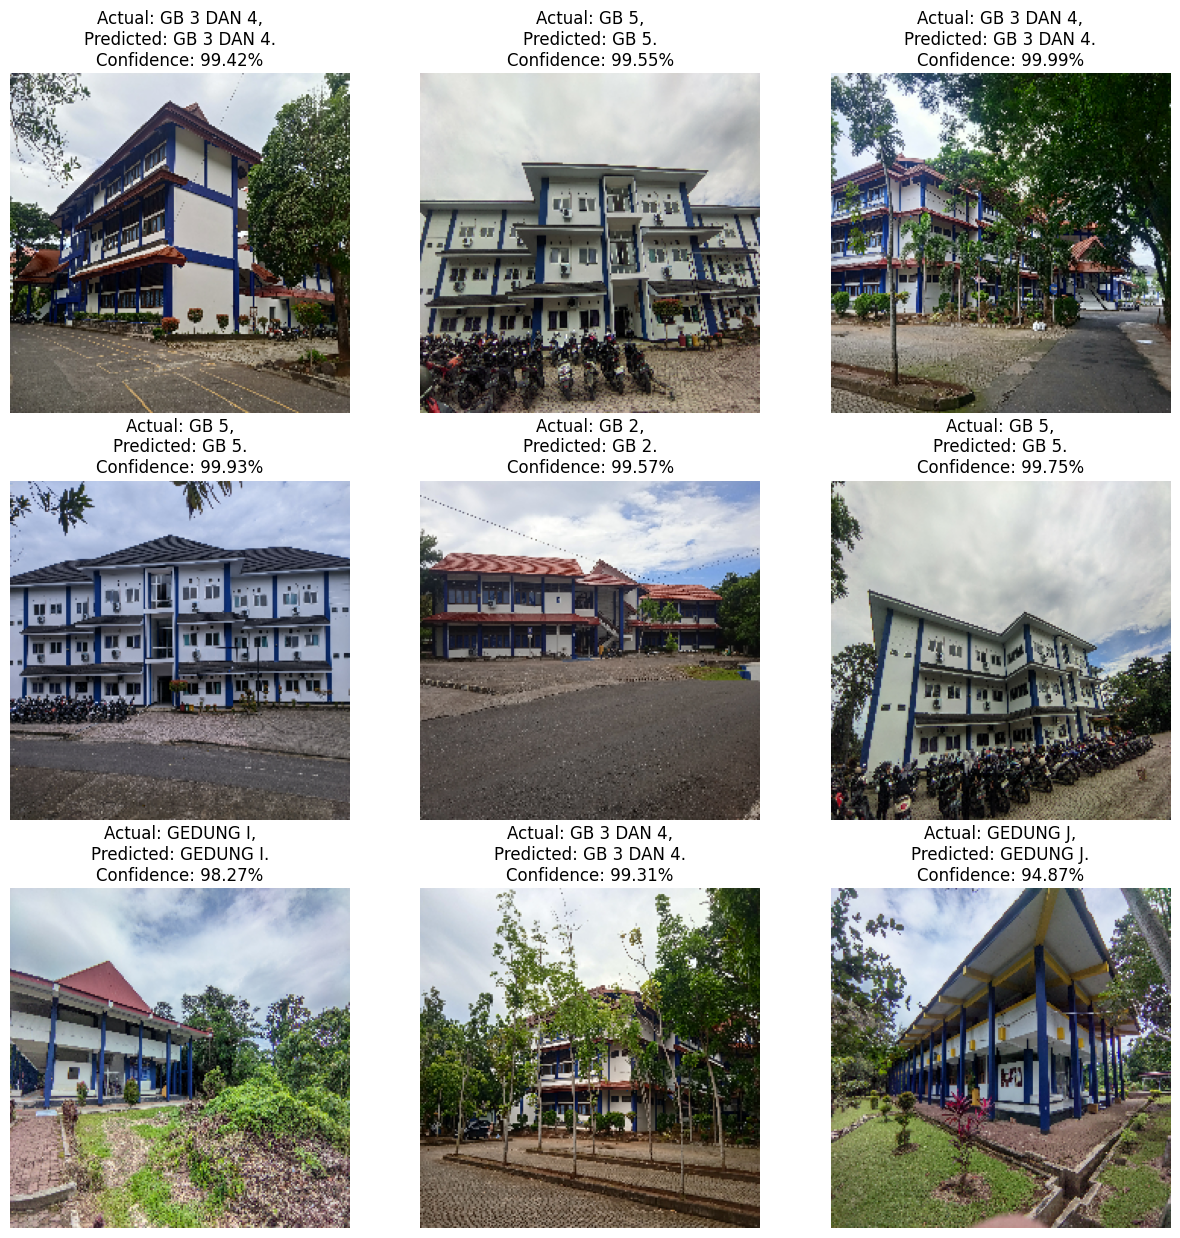

In [ ]:
from tensorflow import expand_dims

# Definisi fungsi prediksi
def predict(model, img):
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)  # batch dimension
    predictions = model.predict(img_array)
    predicted_class = predictions.argmax(axis=-1)[0]
    confidence = predictions.max(axis=-1)[0]
    return predicted_class, confidence


plt.figure(figsize=(15, 15))

for images, lbs in test_data.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i].numpy()]

        plt.title(f"Actual: {actual_class},\nPredicted: {labels[predicted_class]}.\nConfidence: {confidence*100:.2f}%")
        plt.axis("off")

plt.show()

In [ ]:
predictions = model.predict(test_data)

y_pred = []
y_true = []

for image_batch, label_batch in test_data:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
target_names = train_data.class_names
target_names.remove('model')

In [ ]:
from sklearn.metrics import classification_report

# Mendapatkan nama kelas dari dataset
target_names = train_data.class_names

# Cetak classification report
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

        GB 1       1.00      1.00      1.00         2
        GB 2       1.00      1.00      1.00         6
  GB 3 DAN 4       1.00      1.00      1.00         6
        GB 5       1.00      1.00      1.00        13
    GEDUNG A       1.00      1.00      1.00         4
    GEDUNG I       1.00      1.00      1.00         5
    GEDUNG J       1.00      1.00      1.00         6

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



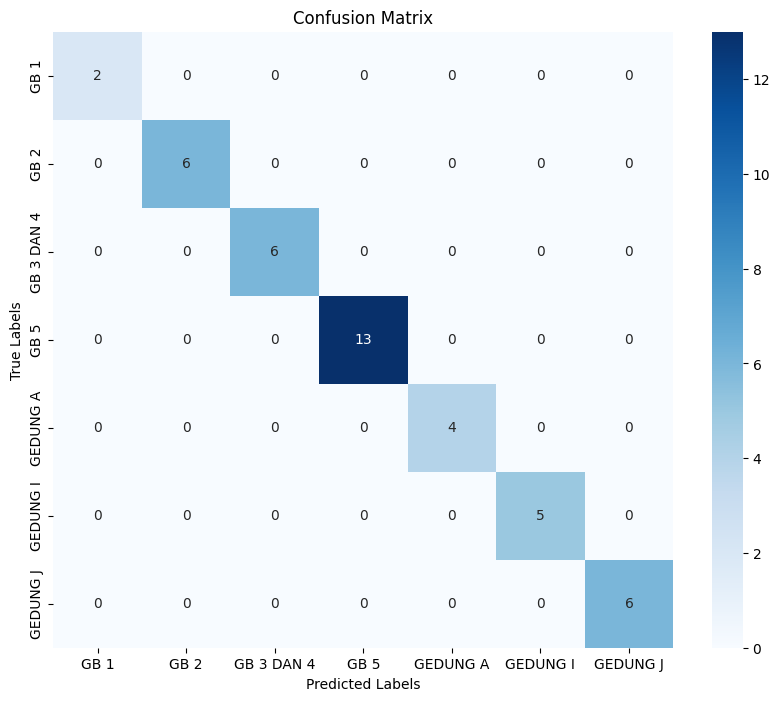

In [ ]:
from sklearn.metrics import confusion_matrix

# Menghitung confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Membuat heatmap confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
